In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import argparse
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import seaborn as sns
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path
from transformers.generation.utils import GenerationMixin
from PIL import Image
import torch.nn.functional as F
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer
import torchvision.transforms as transforms
import numpy as np
import sys


def load_image(image_file):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

if "ipykernel_launcher" in sys.argv[0]:
    sys.argv = sys.argv[:1]

parser = argparse.ArgumentParser()

parser.add_argument("--model-path", type=str, default="/code/yingqi/models/liuhaotian/llava-v1.5-7b")
parser.add_argument("--model-base", type=str, default=None)
parser.add_argument("--image-file", type=str, default=None)
parser.add_argument("--device", type=str, default="cuda")
parser.add_argument("--conv-mode", type=str, default="vicuna_v1")
parser.add_argument("--answer-with-sentence", type=bool, default=False)
parser.add_argument("--num-chunks", type=int, default=1)
parser.add_argument("--chunk-idx", type=int, default=0)
parser.add_argument("--temperature", type=float, default=0)
parser.add_argument("--top_p", type=float, default=None)
parser.add_argument("--num_beams", type=int, default=1)
parser.add_argument("--max_new_tokens", type=int, default=128)
parser.add_argument("--load-8bit", action="store_true")
parser.add_argument("--load-4bit", action="store_true")
parser.add_argument("--debug", action="store_true")
args = parser.parse_args()

disable_torch_init()

model_name = get_model_name_from_path(args.model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(args.model_path, args.model_base, model_name, args.load_8bit, args.load_4bit, device=args.device)

if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

_StoreAction(option_strings=['--model-path'], dest='model_path', nargs=None, const=None, default='/code/yingqi/models/liuhaotian/llava-v1.5-7b', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--model-base'], dest='model_base', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--image-file'], dest='image_file', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--device'], dest='device', nargs=None, const=None, default='cuda', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--conv-mode'], dest='conv_mode', nargs=None, const=None, default='vicuna_v1', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--answer-with-sentence'], dest='answer_with_sentence', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--num-chunks'], dest='num_chunks', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--chunk-idx'], dest='chunk_idx', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--temperature'], dest='temperature', nargs=None, const=None, default=0, type=<class 'float'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--top_p'], dest='top_p', nargs=None, const=None, default=None, type=<class 'float'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--num_beams'], dest='num_beams', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

_StoreAction(option_strings=['--max_new_tokens'], dest='max_new_tokens', nargs=None, const=None, default=128, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

_StoreTrueAction(option_strings=['--load-8bit'], dest='load_8bit', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

_StoreTrueAction(option_strings=['--load-4bit'], dest='load_4bit', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

_StoreTrueAction(option_strings=['--debug'], dest='debug', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/envs/llava-visipruner/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [02:54<00:00, 87.25s/it] 


In [5]:
if args.conv_mode is not None and conv_mode != args.conv_mode:
    print('[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}'.format(conv_mode, args.conv_mode, args.conv_mode))
else:
    args.conv_mode = conv_mode

conv = conv_templates[args.conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

IMAGE_PATH = "/code/yingqi/LLaVA_visiPruner/514915.jpg"
inp = "Is there any scooter in the image?\nAnswer with a single word or short phrase."
image = load_image(IMAGE_PATH)
image_size = image.size
# Similar operation in model_worker.py
image_tensor = process_images([image], image_processor, model.config)
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

print(f"{roles[1]}: ", end="")

if image is not None:
    # first message
    if model.config.mm_use_im_start_end:
        inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    else:
        inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
    image = None

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

with torch.inference_mode():
    output = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample= False,
        temperature=0,
        max_new_tokens=args.max_new_tokens,
        streamer=streamer,
        output_hidden_states=True,
        output_attentions=True,
        return_dict_in_generate=True  # Return as a dictionary so you can access attentions
    )

[WARNING] the auto inferred conversation mode is llava_v1, while `--conv-mode` is vicuna_v1, using vicuna_v1
ASSISTANT: 

/opt/conda/envs/llava-visipruner/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Yes


/tmp/ipykernel_1627/269903895.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored = cm.get_cmap(cmap)(np.array(heat_img)/255.0)[..., :3]


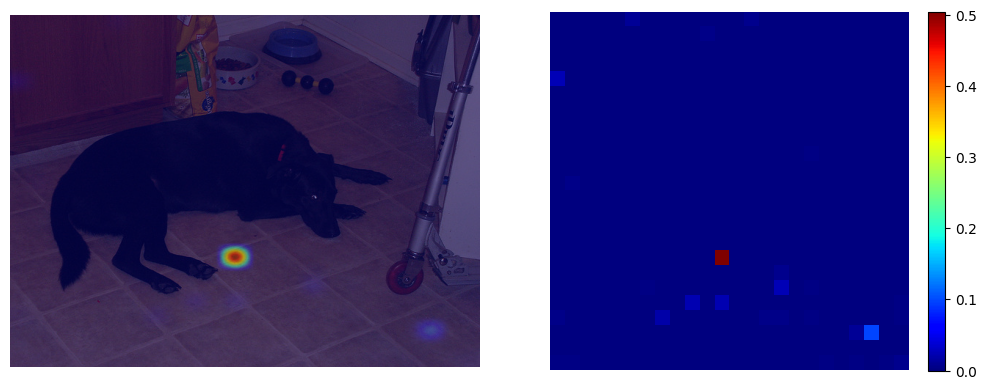

In [9]:
vlm_attn_weights = torch.stack(output['attentions'][0]).mean(dim=2)


def visualize_patch_vector(patch_vec,
                           image_path,
                           has_cls=False,
                           normalize=True,
                           cmap='jet',
                           alpha=0.45,
                           save_path=None,
                           show_colorbar=True):
    v = np.array(patch_vec)
    if v.ndim == 2 and v.shape[0] == 1:
        v = v[0]
    N = v.shape[0]
    side = int(round(math.sqrt(N)))
    if side * side != N:
        raise ValueError(f"Can not be resized to a square: N={N}")
    if normalize:
        s = v.sum()
        if s > 0:
            v = v / s
    heat = v.reshape(side, side)

    img = Image.open(image_path).convert("RGB")
    W, H = img.size

    hmin, hmax = heat.min(), heat.max()
    if hmax > hmin:
        norm_heat = (heat - hmin) / (hmax - hmin)
    else:
        norm_heat = np.zeros_like(heat)

    heat_img = Image.fromarray((norm_heat * 255).astype(np.uint8)).resize((W, H), Image.BICUBIC)
    colored = cm.get_cmap(cmap)(np.array(heat_img)/255.0)[..., :3]
    colored = (colored * 255).astype(np.uint8)
    colored_img = Image.fromarray(colored)
    blended = Image.blend(img, colored_img, alpha=alpha)

    cols = 2 if show_colorbar else 1
    fig, axs = plt.subplots(1, cols, figsize=(10,4))
    axs[0].imshow(blended); axs[0].axis('off')
    if show_colorbar:
        im = axs[1].imshow(heat, cmap=cmap)
        axs[1].axis('off')
        plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_path:
        blended.save(save_path)
    plt.show()

layer_idx = 2
patch_vec = vlm_attn_weights[layer_idx,0,-1,35:611].cpu().numpy()
visualize_patch_vector(patch_vec, IMAGE_PATH)

## Layer-wise Visualization

In [10]:
self_attention = output.attentions[0]
img_token_idx = int(torch.where(input_ids == -200)[1][0])
attention_grids = []
for layer in self_attention:
    averaged_head_attention = torch.mean(layer, axis=1)[0].float()
    vision_attention = averaged_head_attention[:, img_token_idx:img_token_idx + 576]
    flat_vision_attention = vision_attention[-1,:].resize(24,24).cpu().detach().numpy()
    attention_grids.append(flat_vision_attention)

/opt/conda/envs/llava-visipruner/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
image_path = IMAGE_PATH 
image = Image.open(image_path)
image = transforms.Resize((  int(image.size[0]/2), int(image.size[1]/2)))(image)

total_layers = len(self_attention)
for layer_index in range(total_layers):
    multihead_attention = self_attention[layer_index].cpu()
    averaged_attention = torch.mean(multihead_attention, axis=1)[0].float()
    averaged_attention = torch.nn.functional.avg_pool2d(averaged_attention.unsqueeze(0).unsqueeze(0), 10, stride=10).squeeze(0).squeeze(0)
    
    cmap = plt.cm.get_cmap("viridis")
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300, gridspec_kw={'height_ratios': [1, 0.5]})

    log_norm = LogNorm(vmin=0.0007, vmax=averaged_attention.max())
    sns.heatmap(averaged_attention,
                cmap=cmap,
                norm=log_norm,
                ax=ax1,
                cbar=False,
                linewidths=0
                )

    x_ticks = [str(i*10) for i in range(0, averaged_attention.shape[0])]
    y_ticks = [str(i*10) for i in range(0, averaged_attention.shape[0])]
    ax1.set_xticks([i for i in range(0, averaged_attention.shape[0])])
    ax1.set_yticks([i for i in range(0, averaged_attention.shape[0])])
    ax1.set_xticklabels(x_ticks, fontsize=6, rotation=90)
    ax1.set_yticklabels(y_ticks, fontsize=6)
    ax1.set_title("Attention Map of Layer " + str(layer_index), fontsize=10)

    tensor_grid = attention_grids[layer_index]
    im = ax2.imshow(tensor_grid, cmap='viridis')
    ax2.set_xlabel('Column', fontsize=8)
    ax2.set_ylabel('Row', fontsize=8)
    ax2.set_title('Attention from last input token to visual tokens of Layer ' + str(layer_index), fontsize=10)

    grid_h, grid_w = tensor_grid.shape[0]-1, tensor_grid.shape[1]-1
    
    ax2.imshow(image, cmap='gray', alpha=0.7, extent=(0, grid_w, grid_h, 0))
    ax2.set_xlim(0, grid_w - 1)
    ax2.set_ylim(grid_h - 1, 0)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(mappable=im, cax=cbar_ax)
    cbar.set_label('Value', rotation=270, labelpad=20, fontsize=10)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.savefig(f"./prefill_attn/attn_map_grid_{layer_index}.svg", format="svg", bbox_inches='tight', dpi=300)
    plt.close(fig)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 0')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 0')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 1')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 1')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 2')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 2')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 3')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 3')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 4')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 4')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 5')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 5')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 6')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 6')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 7')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 7')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 8')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 8')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 9')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 9')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 10')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 10')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 11')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 11')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 12')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 12')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 13')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 13')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 14')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 14')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 15')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 15')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 16')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 16')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 17')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 17')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 18')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 18')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 19')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 19')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 20')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 20')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 21')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 21')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 22')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 22')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 23')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 23')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 24')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 24')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 25')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 25')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 26')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 26')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 27')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 27')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 28')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 28')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 29')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 29')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 30')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 30')

(0.0, 22.0)

(22.0, 0.0)

/tmp/ipykernel_1627/3125494494.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis")


<Axes: >

[Text(0, 0, '0'),
 Text(1, 0, '10'),
 Text(2, 0, '20'),
 Text(3, 0, '30'),
 Text(4, 0, '40'),
 Text(5, 0, '50'),
 Text(6, 0, '60'),
 Text(7, 0, '70'),
 Text(8, 0, '80'),
 Text(9, 0, '90'),
 Text(10, 0, '100'),
 Text(11, 0, '110'),
 Text(12, 0, '120'),
 Text(13, 0, '130'),
 Text(14, 0, '140'),
 Text(15, 0, '150'),
 Text(16, 0, '160'),
 Text(17, 0, '170'),
 Text(18, 0, '180'),
 Text(19, 0, '190'),
 Text(20, 0, '200'),
 Text(21, 0, '210'),
 Text(22, 0, '220'),
 Text(23, 0, '230'),
 Text(24, 0, '240'),
 Text(25, 0, '250'),
 Text(26, 0, '260'),
 Text(27, 0, '270'),
 Text(28, 0, '280'),
 Text(29, 0, '290'),
 Text(30, 0, '300'),
 Text(31, 0, '310'),
 Text(32, 0, '320'),
 Text(33, 0, '330'),
 Text(34, 0, '340'),
 Text(35, 0, '350'),
 Text(36, 0, '360'),
 Text(37, 0, '370'),
 Text(38, 0, '380'),
 Text(39, 0, '390'),
 Text(40, 0, '400'),
 Text(41, 0, '410'),
 Text(42, 0, '420'),
 Text(43, 0, '430'),
 Text(44, 0, '440'),
 Text(45, 0, '450'),
 Text(46, 0, '460'),
 Text(47, 0, '470'),
 Text(48, 0, 

[Text(0, 0, '0'),
 Text(0, 1, '10'),
 Text(0, 2, '20'),
 Text(0, 3, '30'),
 Text(0, 4, '40'),
 Text(0, 5, '50'),
 Text(0, 6, '60'),
 Text(0, 7, '70'),
 Text(0, 8, '80'),
 Text(0, 9, '90'),
 Text(0, 10, '100'),
 Text(0, 11, '110'),
 Text(0, 12, '120'),
 Text(0, 13, '130'),
 Text(0, 14, '140'),
 Text(0, 15, '150'),
 Text(0, 16, '160'),
 Text(0, 17, '170'),
 Text(0, 18, '180'),
 Text(0, 19, '190'),
 Text(0, 20, '200'),
 Text(0, 21, '210'),
 Text(0, 22, '220'),
 Text(0, 23, '230'),
 Text(0, 24, '240'),
 Text(0, 25, '250'),
 Text(0, 26, '260'),
 Text(0, 27, '270'),
 Text(0, 28, '280'),
 Text(0, 29, '290'),
 Text(0, 30, '300'),
 Text(0, 31, '310'),
 Text(0, 32, '320'),
 Text(0, 33, '330'),
 Text(0, 34, '340'),
 Text(0, 35, '350'),
 Text(0, 36, '360'),
 Text(0, 37, '370'),
 Text(0, 38, '380'),
 Text(0, 39, '390'),
 Text(0, 40, '400'),
 Text(0, 41, '410'),
 Text(0, 42, '420'),
 Text(0, 43, '430'),
 Text(0, 44, '440'),
 Text(0, 45, '450'),
 Text(0, 46, '460'),
 Text(0, 47, '470'),
 Text(0, 48, 

Text(0.5, 1.0, 'Attention Map of Layer 31')

Text(0.5, 242.16666666666694, 'Column')

Text(187.79166666666666, 0.5, 'Row')

Text(0.5, 1.0, 'Attention from last input token to vision of Layer 31')

(0.0, 22.0)

(22.0, 0.0)